In [1]:
import numpy as np
from sif.kernels import BrownianMotionKernel
from sif.samplers import multivariate_normal_sampler

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
n_grid = 1000
T = np.atleast_2d(np.linspace(1e-6, 1, num=n_grid)).T
kernel = BrownianMotionKernel()

In [4]:
n_samples = 20000

In [5]:
C = kernel.cov(T)
m = np.zeros((T.shape[0], ))
B = multivariate_normal_sampler(m, C, n_samples=n_samples)
Theta = np.sin(B) * B - 2 * T.ravel()

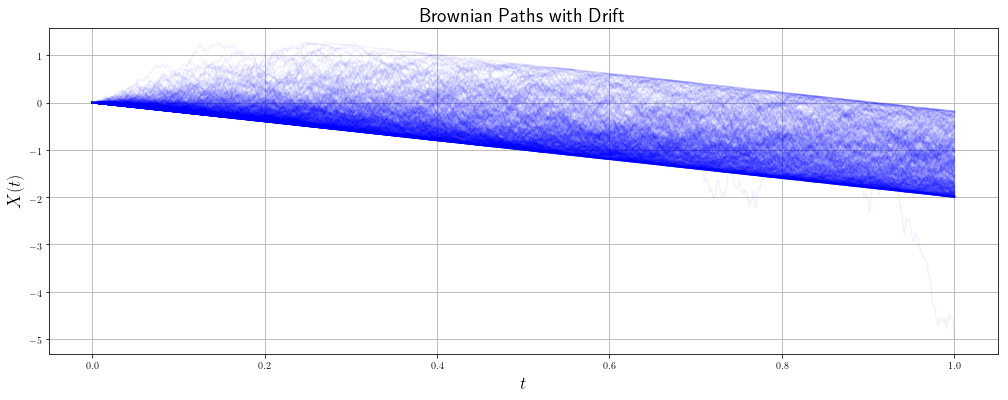

In [6]:
plt.figure(figsize=(17, 6))
for i in range(min(500, n_samples)):
    plt.plot(T.ravel(), Theta[i], "b-", alpha=0.05)
plt.grid()
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$X(t)$", fontsize=18)
plt.title("Brownian Paths with Drift", fontsize=20)
plt.show()

In [7]:
# This, on the other hand, was completely wrong.
# dB = np.hstack((np.zeros((n_samples, 1)), np.diff(B, axis=1)))

dt = T[1] - T[0]
dB = np.hstack((np.diff(B, axis=1), np.zeros((n_samples, 1))))
alpha = -np.cumsum(Theta*dB, axis=1)
beta = -0.5 * np.cumsum((Theta**2) * dt, axis=1)
delta = np.cumsum(Theta * dt, axis=1)
B_tilde = B + delta

In [8]:
Z = np.exp(alpha + beta)

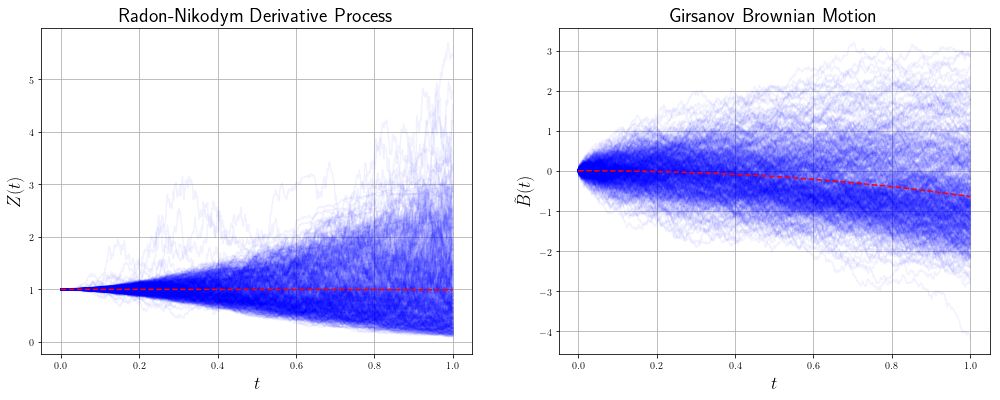

In [9]:
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
for i in range(min(500, n_samples)):
    plt.plot(T.ravel(), Z[i], "b-", alpha=0.05)
plt.plot(T.ravel(), Z.mean(axis=0), "r--")
plt.grid()
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$Z(t)$", fontsize=18)
plt.title("Radon-Nikodym Derivative Process", fontsize=20)

plt.subplot(1, 2, 2)
for i in range(min(500, n_samples)):
    plt.plot(T.ravel(), B_tilde[i], "b-", alpha=0.05)
plt.plot(T.ravel(), B_tilde.mean(axis=0), "r--")
plt.grid()
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$\\tilde{B}(t)$", fontsize=18)
plt.title("Girsanov Brownian Motion", fontsize=20)

plt.show()

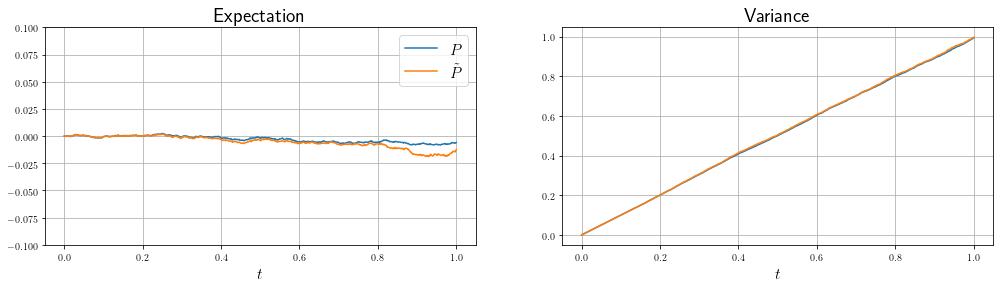

In [10]:
plt.figure(figsize=(17, 4))

plt.subplot(1, 2, 1)
plt.plot(T.ravel(), B.mean(axis=0), label="$P$")
plt.plot(T.ravel(), (B_tilde * Z).mean(axis=0), label="$\\tilde{P}$")
plt.grid()
plt.gca().set_title("Expectation", fontsize=20)

plt.ylim((-0.1, 0.1))
plt.legend(fontsize=16)
plt.xlabel("$t$", fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(T.ravel(), B.var(axis=0))
# This is a very subtle point.
plt.plot(T.ravel(), ((B_tilde**2) * Z).mean(axis=0) - (B_tilde * Z).mean(axis=0)**2)
plt.grid()
plt.xlabel("$t$", fontsize=16)
plt.gca().set_title("Variance", fontsize=20)

plt.show()

In [11]:
if False:
    K_tilde = np.zeros((n_grid, n_grid))
    M = np.zeros((n_grid, n_grid))
    N = np.zeros((n_grid, n_grid))
    for i in range(n_grid):
        if (i+1) % 100 == 0:
            print(i+1)
        for j in range(i, n_grid):
            B_i, B_j = B_tilde[:, i], B_tilde[:, j]
            Z_i, Z_j = Z[:, i], Z[:, j]
            M[i,j] = M[j,i] = np.mean(B_i*B_j*Z_j)
            N[i,j] = N[j,i] = np.mean(B_i*Z_i)*np.mean(B_j*Z_j)
            K_tilde[i, j] = np.mean(B_i*B_j*Z_j) - np.mean(B_i*Z_i)*np.mean(B_j*Z_j)
            K_tilde[j, i] = K_tilde[i, j]

In [13]:
R = np.outer(np.mean(B_tilde * Z, axis=0), np.mean(B_tilde * Z, axis=0))
S = B_tilde.T.dot(B_tilde * Z) / n_samples
i_lower = np.tril_indices(n_grid, -1)
S[i_lower] = S.T[i_lower]
K_tilde = S - R

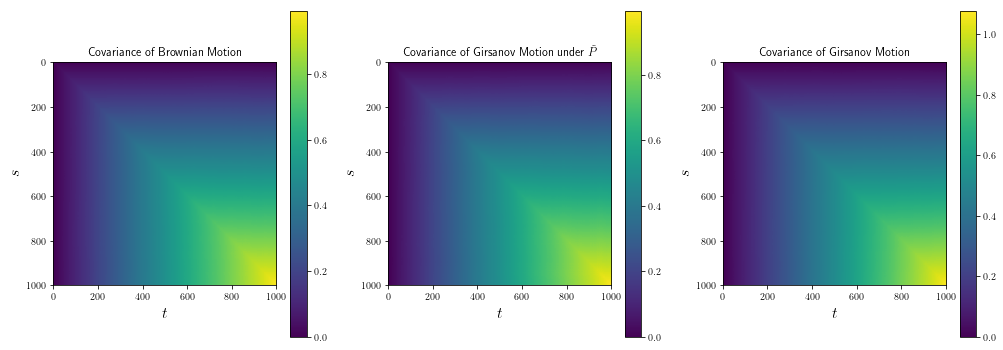

In [14]:
K = np.cov(B.T)

plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
plt.imshow(K)
plt.xlabel("$t$", fontsize=16)
plt.ylabel("$s$", fontsize=16)
plt.title("Covariance of Brownian Motion")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(K_tilde)
plt.xlabel("$t$", fontsize=16)
plt.ylabel("$s$", fontsize=16)
plt.title("Covariance of Girsanov Motion under $\\tilde{P}$")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.cov(B_tilde.T))
plt.xlabel("$t$", fontsize=16)
plt.ylabel("$s$", fontsize=16)
plt.title("Covariance of Girsanov Motion")
plt.colorbar()

plt.show()

In [15]:
np.sum(B*dB, axis=1)

array([ 0.92160109, -0.48648224, -0.02739607, ...,  0.2744572 ,
        1.56510667, -0.46405477])

In [16]:
0.5*B[:, -1]**2 - 0.5 * 1

array([ 9.54091407e-01, -4.72434693e-01,  4.20905561e-04, ...,
        2.69300780e-01,  1.53462216e+00, -4.84503504e-01])